In [1]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if device == "cuda" else torch.float32

2025-04-18 08:01:54.762462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744977714.773382    8504 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744977714.776725    8504 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-18 08:01:54.789287: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Could not load bitsandbytes native library: 'NoneType' object has no attribute 'split'
Traceback (most recent call last):
  F

In [2]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch_dtype
)
pipe = pipe.to(device)
pipe.enable_attention_slicing() 
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
pipe.scheduler.set_timesteps(40)

In [4]:
prompt = "a futuristic cityscape"
text_input = pipe.tokenizer(prompt, padding="max_length", max_length=pipe.tokenizer.model_max_length, return_tensors="pt")

In [5]:
text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]

/home/shaunak/.virtualenvs/ML/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
  return F.linear(input, self.weight, self.bias)


In [6]:
text_embeddings.requires_grad_(True)
text_embeddings.retain_grad()

In [7]:
text_embeddings.requires_grad

True

In [8]:
# with torch.no_grad():
with torch.enable_grad():
    latents = torch.randn((1, pipe.unet.in_channels, 64, 64), device=device)  # typical latent size
    latents = latents.to(torch_dtype) * pipe.scheduler.init_noise_sigma  # match scheduler expectations

/tmp/ipykernel_8504/36194376.py:3: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, pipe.unet.in_channels, 64, 64), device=device)  # typical latent size


In [9]:
x = latents

In [10]:
import torch.utils.checkpoint as cp

def unet_forward(model_input, t, text_embeds):
    return pipe.unet(model_input, t, encoder_hidden_states=text_embeds).sample


for i, t in enumerate(pipe.scheduler.timesteps):
    model_input = pipe.scheduler.scale_model_input(x, t)
    print(i, end = " ")
    # dummy = torch.tensor(0.0, requires_grad=True, device=model_input.device)
    # Apply checkpointing
    noise_pred = cp.checkpoint(unet_forward, model_input, t, text_embeddings)

    scheduler_output = pipe.scheduler.step(noise_pred, t, x)
    x = scheduler_output.prev_sample

/home/shaunak/.virtualenvs/ML/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

In [11]:
pipe.vae.eval()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [12]:
x.retain_grad()
with torch.enable_grad():
    intermediates = x / 0.18215
    intermediates.retain_grad()
    # intermediates = intermediates.to(device).to(torch_dtype)
    image = pipe.vae.decode(intermediates)
    image = image.sample   
# image = x

In [13]:
image_mean = image.sum()
image_mean.backward()
print("x grad : ", x.grad)

x grad :  tensor([[[[ 102.2500,   81.5000,   91.6250,  ...,   70.7500,   74.5000,
             62.5000],
          [  91.1875,  102.9375,   88.6875,  ...,   76.5625,   91.6250,
             58.2812],
          [  88.8750,   90.4375,   74.0000,  ...,   74.6875,   75.8125,
             74.8125],
          ...,
          [  88.1250,   80.6875,   64.6875,  ...,  102.6250,   86.7500,
            100.4375],
          [  70.6250,   59.9062,   98.3125,  ...,  102.9375,   71.4375,
            103.6875],
          [  70.7500,   96.0000,   90.9375,  ...,   85.3125,   80.6250,
            105.8750]],

         [[  65.8125,   83.9375,   97.1250,  ...,   53.5312,   56.3438,
             54.7188],
          [  66.0625,   73.3125,   71.9375,  ...,   60.0000,   59.7812,
             68.1250],
          [  77.3125,   71.4375,   61.9062,  ...,   76.1250,   72.1250,
             54.8438],
          ...,
          [  53.6562,  105.3125,  106.1250,  ...,   75.2500,   64.8750,
             71.5625],
        

In [14]:
specials = {
    "bos_token": pipe.tokenizer.bos_token,
    "eos_token": pipe.tokenizer.eos_token,
    "pad_token": pipe.tokenizer.pad_token,
    "unk_token": pipe.tokenizer.unk_token,
    "additional_special_tokens": pipe.tokenizer.additional_special_tokens,
}

special_token_ids = set()

# Add basic special tokens
for attr in ["bos_token", "eos_token", "pad_token", "unk_token"]:
    token = getattr(pipe.tokenizer, attr, None)
    if token is not None:
        token_id = pipe.tokenizer.convert_tokens_to_ids(token)
        special_token_ids.add(token_id)

# Add additional special tokens (if any)
for token in pipe.tokenizer.additional_special_tokens:
    token_id = pipe.tokenizer.convert_tokens_to_ids(token)
    special_token_ids.add(token_id)

special_ids_tensor = torch.tensor(list(special_token_ids), device="cpu")
mask = ~torch.isin(text_input.input_ids[0], special_ids_tensor)
importance = (text_embeddings.grad[0, mask] * text_embeddings[0, mask]).norm(dim=-1)
final_importance = importance
if importance.norm() > 0:
    final_importance /= importance.norm()
token_ids = text_input.input_ids[0, mask]
for i, token_id in enumerate(token_ids):
    imp = final_importance[i]
    word = pipe.tokenizer.decode(token_id)
    print(f"Token: {word}, importance: {imp}")


Token: a, importance: 0.205322265625
Token: futuristic, importance: 0.438232421875
Token: cityscape, importance: 0.875


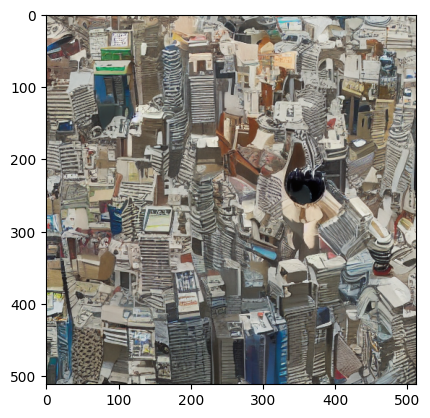

In [15]:
import numpy as np
img_np = image.detach().cpu().squeeze().permute(1, 2, 0).numpy().astype(np.float32) # Squeeze if you want to remove the channel dimension
# img_np = (img_np + 1.0) / 2.0
img_np = (img_np / 2 + 0.5)
img_np = np.clip(img_np, 0, 1)
import matplotlib.pyplot as plt
# Plot using matplotlib
plt.imshow(img_np, cmap='gray')